Test Data Age statistics:
count     186.000000
mean      905.021505
std       218.125694
min       212.500000
25%       775.250000
50%       899.500000
75%       999.500000
max      1462.500000
Name: Age, dtype: float64
Found 186 validated image filenames.


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 857032.4375 - mae: 905.4002
Test Loss: 865261.25
Test MAE: 904.4134521484375
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


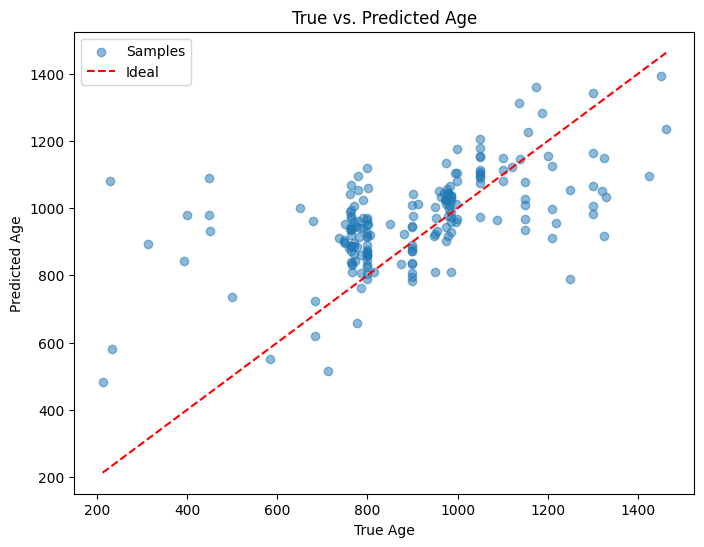

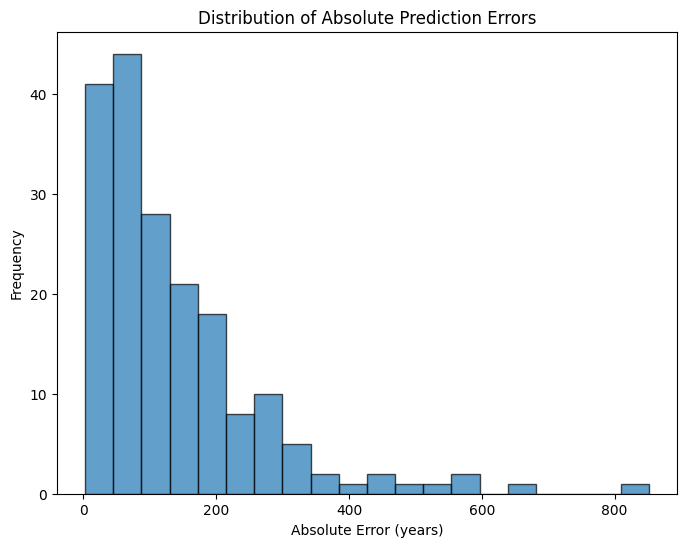

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pickle

# ------------------------------
# 1. Load Test Data
# ------------------------------
# Load your test CSV (which should include only original images)
test_df = pd.read_csv("test_dataset.csv")

# Ensure the Age column is numeric and drop rows with invalid ages
test_df['Age'] = pd.to_numeric(test_df['Age'], errors='coerce')
test_df = test_df.dropna(subset=['Age'])
print("Test Data Age statistics:")
print(test_df['Age'].describe())

# ------------------------------
# 2. Create a Test Data Generator
# ------------------------------
# Use ImageDataGenerator for scaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator.
# If your CSV's "Image" column contains full relative paths (e.g., "artifact_dataset/images/coin/457172.jpg"),
# set directory='' so that the generator uses the path as-is.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",        # Column with image paths
    y_col="Age",          # True age values
    directory='',         # Set to '' if the Image column already has relative paths
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

# ------------------------------
# 3. Load Model and Scaler
# ------------------------------
model = load_model("final_artifact_date_model.keras")
with open("age_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# ------------------------------
# 4. Evaluate the Model
# ------------------------------
results = model.evaluate(test_generator)
print("Test Loss:", results[0])
print("Test MAE:", results[1])

# ------------------------------
# 5. Predict on Test Data and Visualize
# ------------------------------
# Get predictions (these are scaled predictions)
preds_scaled = model.predict(test_generator)

# Inverse transform predictions to obtain actual age values
preds = scaler.inverse_transform(preds_scaled)

# Extract true ages (ensure they are in the same order as predictions)
true_ages = test_df['Age'].values

# Scatter Plot: True Age vs Predicted Age
plt.figure(figsize=(8,6))
plt.scatter(true_ages, preds, alpha=0.5, label="Samples")
plt.plot([min(true_ages), max(true_ages)], [min(true_ages), max(true_ages)], 'r--', label="Ideal")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True vs. Predicted Age")
plt.legend()
plt.show()

# Histogram: Distribution of Absolute Errors
errors = np.abs(true_ages - preds.flatten())
plt.figure(figsize=(8,6))
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Absolute Error (years)")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Prediction Errors")
plt.show()


In [3]:
 #Manually Compute Error on Unscaled Data
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pickle

# 1) Load the unscaled test DataFrame
test_df = pd.read_csv("test_dataset.csv")
test_df['Age'] = pd.to_numeric(test_df['Age'], errors='coerce')
test_df = test_df.dropna(subset=['Age'])

# 2) Create a test generator with class_mode=None (or 'raw' but we won't use y_col here)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",       # only the images
    y_col=None,          # we won't use the generator's labels
    directory='',
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,     # no labels needed here
    shuffle=False
)

# 3) Load your model and scaler
model = load_model("final_artifact_date_model.keras")
with open("age_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# 4) Predict on the test images (scaled predictions)
preds_scaled = model.predict(test_generator)

# 5) Inverse transform predictions to get them back in [212..1462] range
preds_unscaled = scaler.inverse_transform(preds_scaled)

# 6) Compute errors manually on unscaled data
true_ages_unscaled = test_df['Age'].values  # original, unscaled ages
errors = preds_unscaled.flatten() - true_ages_unscaled

mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print(f"Manual Evaluation on Unscaled Data:")
print(f"  MAE  = {mae:.2f}")
print(f"  MSE  = {mse:.2f}")
print(f"  RMSE = {rmse:.2f}")
#a realistic MAE of around 137 years which is a substantial improvement over the previous 900+ caused by scale mismatches

Found 186 validated image filenames.


C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Manual Evaluation on Unscaled Data:
  MAE  = 136.66
  MSE  = 35214.80
  RMSE = 187.66
